In [114]:
from collections import defaultdict
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
from scipy.cluster.hierarchy import dendrogram
from typing import Callable, Dict, List, Set, Tuple

# Report

### Names

Ethan Pedersen

### Abstract

foo

### Introduction

foo

### Helper Code

In [6]:
class MixedNetworkFormation:
    def __init__(self, M=None, poisson_lambda = 5, num_edges = 200):
        ### Initialize Algorithm with four types using Equation 3 ###
        if M is None:
            self.M = np.array([[0.4, 0.02, 0.01, 0.03],
                [0.02, 0.4, 0.03, 0.02],
                [0.01, 0.03, 0.4, 0.01],
                [0.03, 0.02, 0.01, 0.4]]) # Mixing matrix
        else: self.M = M

        # Number of node types equals dimension of M matrix
        self.type_list = [i for i in range(len(M))]
        self.color_template = ['y', 'b', 'm', 'c', 'k'] 

        # Create empty graph
        self.G = nx.Graph()
        
        # Run the algorithm
        self._AlgorithmStep1(poisson_lambda)
        self._AlgorithmStep2(num_edges)
        self._AlgorithmStep3()
        self._AlgorithmStep4()

        ### Set graph properties ### 
        self.color_map = self._getColorMap()        

    """ Public methods """
    def getGraph(self): return self.G
    def getGroundTruthColors(self): return self.color_map   
    def getColorTemplate(self): return self.color_template
    def getAverageDegree(self): return(np.average([self.G.degree(n) for n in self.G.nodes]))
    
    """ Private methods """
    ### Graph Helpers 
    def _getColorMap(self):
        color_map = []
        num_colors = len(self.color_template)
        for node in self.G.nodes: 
            color_map.append(self.color_template[self.G.nodes[node]['type']%num_colors])
        return color_map

    ### Algorithm Step 1 ###
    def _AlgorithmStep1(self, poisson_lambda):
        self.PoissonLambda = poisson_lambda
   
    ### Algorithm Step 2 ###
    def _AlgorithmStep2(self, num_edges):
        self.num_edges = num_edges # This is how many edges I want
        self.edgeNumbersDict = self._drawEdgesFromMixingMatrix()
        self.endsByTypeDict = self._countEndsOfEdgesByType()
        self.expectedNumberOfNodes = self._computeExpectedNumberOfNodes()
    def _drawEdgesFromMixingMatrix(self):
        edgeNumbersDict = dict()
        # initialize dictionary
        for type1 in self.type_list:
            for type2 in self.type_list:
                if type2>=type1:
                    edgeNumbersDict[(type1,type2)] = 0
        count = 0
        while count < self.num_edges:
            for type1 in self.type_list:
                for type2 in self.type_list:
                    if np.random.uniform(low=0.0,high=1.0) < self.M[type1][type2]:
                        if type2 >= type1: edgeNumbersDict[(type1,type2)] += 1
                        else: edgeNumbersDict[(type2,type1)] += 1
                        count+=1
        #(edgeNumbersDict)
        #print("There are ", sum([edgeNumbersDict[key] for key in edgeNumbersDict.keys()])," edges in the dictionary")
        return edgeNumbersDict
    def _countEndsOfEdgesByType(self):
        endsByTypeDict = {k: 0 for k in self.type_list} # initialize dictionary
        for type1 in self.type_list:
            for type2 in self.type_list:
                if type2<type1: continue
                if type1 == type2: endsByTypeDict[type1] += self.edgeNumbersDict[(type1,type2)]*2
                else: 
                    endsByTypeDict[type1] += self.edgeNumbersDict[(type1,type2)]
                    endsByTypeDict[type2] += self.edgeNumbersDict[(type1,type2)]
        #print("node ends by type ", endsByTypeDict)
        return endsByTypeDict
    def _computeExpectedNumberOfNodes(self):
        numNodeDict = dict()
        for type in self.type_list:
            n = np.round(self.endsByTypeDict[type]/self.PoissonLambda)
            #print(int(n))
            numNodeDict[type] = int(n)
        return numNodeDict

    ### Algorithm Step 3 ###
    def _AlgorithmStep3(self):
        self.nodeListByTypeAndDegree = self._drawNodesFromTypes()
    def _drawNodesFromTypes(self):
        nodesByDegreeDict = {k: [] for k in self.type_list} # initialize to dictionary of empty lists
        for type in self.type_list:
            nodeList = self._drawNodesByType(type)
            nodesByDegreeDict[type] = nodeList
        #print("nodesByDegreeDict = ", nodesByDegreeDict) 
        return nodesByDegreeDict  
    def _drawNodesByType(self,type):
        nodeList = list()
        #print("Trying to get ", self.endsByTypeDict[type]," total degrees")
        while len(nodeList) != self.expectedNumberOfNodes[type]:
            if len(nodeList) < self.expectedNumberOfNodes[type]:
                node = np.random.poisson(lam=self.PoissonLambda)
                if node==0: continue
                nodeList.append(node)
            #print("Number of nodes in node set ", type, " is ", sum(nodeList))
            if len(nodeList) > self.expectedNumberOfNodes[type]:
                nodeList.pop(0)
                #print("Number of nodes in node set ", type, " is ", sum(nodeList))
        #print("Length of nodeList for type ",type, " = ",len(nodeList))
        return nodeList

    ### Algorithm Step 4 ###
    def _AlgorithmStep4(self):
        self._addNodesToGraph()
        self._addEdgesToGraph() # Requires nodes to be added to graph
    def _addNodesToGraph(self):
        # Make the node list into a a format with node_id by type
        nodeList = []
        nodeID = 0
        for type in self.type_list:
            for nodeDegree in self.nodeListByTypeAndDegree[type]:
                nodeList.append((nodeID, {"type":type, "degree":nodeDegree}))
                nodeID += 1
        #print("node list is ", nodeList)
        self.G.add_nodes_from(nodeList)
        return nodeList
    def _addEdgesToGraph(self):
        #print("Adding edges to graph")
        for edge_type in self.edgeNumbersDict.keys():
            type1 = edge_type[0]; type2 = edge_type[1]
            while self.edgeNumbersDict[edge_type] > 0 :
                free_agents1 = self._getFreeAgents(type1)
                free_agents2 = self._getFreeAgents(type2)
                if free_agents1 == [] or free_agents2 == []: break
                node1 = free_agents1[np.random.randint(0,len(free_agents1))]
                neighbors_of_node = [n for n in self.G[node1]]
                neighbors_of_node.append(node1) # If same type, don't allow self loops
                possible_neighbors = list(set(free_agents2) - set(neighbors_of_node))
                if possible_neighbors == []: break
                index2 = np.random.randint(0,high=len(possible_neighbors))
                node2 = possible_neighbors[index2]
                self.G.add_edge(node1,node2)
                self.edgeNumbersDict[edge_type] -= 1
                self._decrementRemainingDegree(node1)
                self._decrementRemainingDegree(node2)
        #print("Done adding edges to graph")
        return 
    def _getFreeAgents(self,type):
        # return agents of specified type that have free stubs
        #print("Graph node info is ", self.G.nodes.data())
        nodes = []
        for node in self.G.nodes.data():
            node_info = list(node)
            node_index = node_info[0]
            node_degree = node_info[1]['degree']
            node_type = node_info[1]['type']
            if node_type == type and node_degree > 0: nodes.append(node_index)
        return nodes
    def _decrementRemainingDegree(self,node_index):
        # subtract one from the nodeList
        self.G.nodes[node_index]['degree'] -= 1
        #print("node ", node_index, " now has remaining degree ", self.G.nodes[node_index]['degree'], "\n\n")
        return

In [7]:
class graphHandler:
    def __init__(self, G, colormap, use_pydot = True):
        self.G = G
        self.color_template = self.color_template = ['y', 'b', 'm', 'c', 'k'] 
        self.color_map = colormap
        if use_pydot: self.pos = nx.nx_pydot.graphviz_layout(self.G,prog='neato')
        else: self.pos = nx.nx_agraph.graphviz_layout(self.G,prog='neato')
    ####################
    ## Public methods ##
    ####################
    def getGraph(self): return self.G
    def showGraph(self,agent_colors = None,title = None):
        if agent_colors == None: agent_colors = self.color_map
        if title == None: title = "Network with " + str(len(self.G.nodes)) + ' agents'
        ax = plt.gca()
        ax.set_title(title)
        nx.draw(self.G,self.pos,node_color = agent_colors, node_size = 70, alpha=0.8)
    def showLouvainCommunities(self, title = None):
        agent_colors = self._getAgentColors_from_LouvainCommunities()
        if title == None: title = "Louvain communities for network with " + str(len(self.G.nodes)) + ' agents'
        ax = plt.gca()
        ax.set_title(title)
        nx.draw(self.G,self.pos,node_color = agent_colors, node_size = 70, alpha=0.8)
    def showDendrogram(self):
        myHandler = DendrogramHandler(self.G)
        Z = myHandler.getLinkMatrix()
        ZLabels = myHandler.getLinkMatrixLabels()
        #plt.figure(figureNumber);plt.clf()
        dendrogram(Z, labels=ZLabels)
        del myHandler
    def show_kCores(self):
        """ Visualize by k-cores. 
        Thanks to [Corralien's response on stackoverflow]
        (https://stackoverflow.com/questions/70297329/visualization-of-k-cores-using-networkx).
        """
        # build a dictionary of k-level with the list of nodes
        kcores = defaultdict(list)
        for n, k in nx.core_number(self.G).items():
            kcores[k].append(n)

        # compute position of each node with shell layout
        pos = nx.layout.shell_layout(self.G, sorted(list(kcores.values())))
        colors = ['black','lightblue','yellow','magenta','olive', 'cyan']
        legend_elements = []

        # draw nodes, edges and labels
        for kcore in sorted(list(kcores.keys()),reverse = True):
            nodes = kcores[kcore]
            nx.draw_networkx_nodes(self.G, pos, nodelist=nodes, node_color=colors[kcore%len(colors)])
            label = f"kcore = {kcore}"
            color = colors[kcore%len(colors)]
            legend_elements.append(Line2D([0], [0], marker='o', color=color, label=label,markerfacecolor=color, markersize=15))
        nx.draw_networkx_edges(self.G, pos, width=0.2)
        nx.draw_networkx_labels(self.G, pos)
        plt.title("K-core layout of network")
        plt.legend(handles = legend_elements, loc = 'best')
    def show_partitions(self, partition_list, title = "Network colored by partitions"):
        plt.figure()
        plt.axis('off')
        for i in range(len(partition_list)):
            nx.draw_networkx_nodes(partition_list[i],self.pos,node_color=self.color_template[i%len(self.color_template)], alpha = 0.8)
        for edge in self.G.edges:
            self._draw_edge_by_type(edge, partition_list)
        nx.draw_networkx_labels(self.G,self.pos)
        if len(partition_list) == 0:
            mod = 0
        else:
            mod = nx.algorithms.community.quality.modularity(self.G,partition_list)
        title = title + ": Modularity = " + str(np.round(mod,2))
        plt.title(title)
    
    #####################
    ## Private methods ##
    #####################
    def _getAgentColors_from_LouvainCommunities(self):
        """ Use the Louvain partition method to break the graph into communities """
        # Louvain method pip install python-louvain
        # see https://arxiv.org/pdf/0803.0476.pdf
        # see https://github.com/taynaud/python-louvain
        color_map = self.color_map
        set_of_partitions = nx.community.louvain_communities(self.G)
        print(f"The Louvain algorithm found {len(set_of_partitions)} partitions.")
        partition_number = 0
        for partition in set_of_partitions:
            for node in partition:
                color_map[node] = self.color_template[partition_number%len(self.color_template)]
            partition_number += 1
        return color_map
    def _draw_edge_by_type(self, edge, partition):
        edge_style = 'dashed'
        for part in partition:
            if edge[0] in part and edge[1] in part:
                edge_style = 'solid'
                break
        nx.draw_networkx_edges(self.G, self.pos, edgelist=[edge], style = edge_style)

In [2]:
# Generic state class
class State:
    def __init__(self, color: str) -> None:
        self.color = color

    def transition(self):
        pass

    def utility(self) -> int:
        pass


# State A
class A(State):
    def __init__(self, color: str = 'cyan') -> None:
        super().__init__(color)

    def transition(self) -> State:
        return self
    
    def utility(self) -> int:
        return 3
    

# State B
class B(State):
    def __init__(self, neighbors: List, color: str = 'blue') -> None:
        super().__init__(color)
        self.neighbors = neighbors

    def transition(self) -> State:
        cumulative_a, cumulative_b = 0, 0

        for neighbor in self.neighbors:
            neighbor_utility = neighbor.prev_state.utility()
            cumulative_a += neighbor_utility if isinstance(neighbor.prev_state, A) else 0
            cumulative_b += neighbor_utility if isinstance(neighbor.prev_state, B) else 0

        return A() if cumulative_a >= cumulative_b else self
    
    def utility(self) -> int:
        return 2

In [3]:
# Agent class (used to represent each node in a graph)
class Agent:
    def __init__(self, initial_state_type: type) -> None:
        assert issubclass(initial_state_type, State)
        self.initial_state_type = initial_state_type
        self.neighbors = []
        self.prev_state, self.curr_state = None, None

    def transition(self) -> None:
        assert self.curr_state is not None
        self.prev_state = self.curr_state
        self.curr_state = self.curr_state.transition()

    def finalize_transition(self) -> None:
        assert self.curr_state is not None
        self.prev_state = self.curr_state

    def add_neighbor(self, neighbor) -> None:
        self.neighbors.append(neighbor)

    def set_initial_state(self) -> None:
        self.curr_state = self._initialize_state()
        self.prev_state = self.curr_state

    def _initialize_state(self) -> State:
        if self.initial_state_type == B:
            return B(neighbors=self.neighbors)
        
        else:
            return A()

In [4]:
# Population class (used to create and handle agents for a graph)
class Population:
    def __init__(self, graph_generator: Callable[[None], nx.Graph], 
                 early_adopters_generator: Callable[[nx.Graph], List[object]]) -> None:
        self.graph_generator = graph_generator
        self.graph = self.graph_generator()
        self.early_adopters_generator = early_adopters_generator
        self.early_adopters = self.early_adopters_generator(self.graph)
        self.agents = self._initialize_agents()

    def _initialize_agents(self) -> Dict:
        agents, nodes = {}, self.graph.nodes

        for node in nodes:
            if node in self.early_adopters:
                initial_state_type = A

            else:
                initial_state_type = B

            agents[node] = Agent(initial_state_type)

        for node in nodes:
            neighbors = self.graph.neighbors(node)

            for neighbor in neighbors:
                neighbor_agent = agents[neighbor]
                agents[node].add_neighbor(neighbor_agent)

            agents[node].set_initial_state()

        return agents
    
    def transition(self) -> None:
        # Calculate what each node's next state should be
        for agent in self.agents.values():
            agent.transition()

        # Apply/set the next states
        for agent in self.agents.values():
            agent.finalize_transition()
    
    def n_agents_with_type(self, state_type: type) -> int:
        assert issubclass(state_type, State)

        n_with_type = 0

        for agent in self.agents.values():
            n_with_type += 1 if isinstance(agent.curr_state, state_type) else 0

        return n_with_type
    
    def nodes_with_type(self, state_type: type) -> List[Tuple[object, str]]:
        nodes_with_type = [(node_label, agent.curr_state.color) for node_label, agent 
                           in self.agents.items() if isinstance(agent.curr_state, state_type)]
        
        return nodes_with_type
    
    def reset(self) -> None:
        self.graph = self.graph_generator()
        self.early_adopters = self.early_adopters_generator(self.graph)
        self.agents = self._initialize_agents()

In [32]:
# Simulation class (used to run simulations on a population and track results)
class Simulation:
    def __init__(self, name: str, population: Population, layout: Dict, n_iterations: int = 20, n_trials: int = 1) -> None:
        self.name = name
        self.population = population
        self.layout = layout
        self.n_iterations = n_iterations
        self.n_trials = n_trials
        self.a_counts, self.b_counts = [], []

    def run(self, show_final_plot: bool = True) -> None:
        node_colors = []
        self.a_counts, self.b_counts = [], []
        self.clustering_coefficients, self.times_to_stop, self.agent_percentages = [], [], []

        for _ in range(self.n_trials):
            a_counts, b_counts = [], []

            for _ in range(self.n_iterations):
                for state_type, count_array in [(A, a_counts), (B, b_counts)]:
                    n_agents_with_type = self.population.n_agents_with_type(state_type)
                    count_array.append(n_agents_with_type)

                if show_final_plot and len(node_colors) < self.n_iterations:
                    colors = []

                    for state_type in [A, B]:
                        nodes_with_type = self.population.nodes_with_type(state_type)
                        colors.extend(nodes_with_type)

                    node_colors.append(colors)

                self.population.transition()

            # Keep track of the two states
            self.a_counts.append(a_counts)
            self.b_counts.append(b_counts)

            # Reset the population for the next trial (if there is a next trial)
            self.population.reset()

        if show_final_plot:
            graph = self.population.graph

            color_mapping = {}
            colors = node_colors[-1]

            for node, color in colors:
                color_mapping[node] = color

            nx.draw(graph, self.layout, with_labels=True, node_color=[color_mapping[node] for node in graph.nodes])
            plt.show()

        return

    def plot(self, show_iqr: bool = False) -> None:
        assert len(self.a_counts) == len(self.b_counts) == self.n_trials
        assert len(self.a_counts[0]) == len(self.b_counts[0]) == self.n_iterations

        x_vals = range(self.n_iterations)

        a_mean = np.mean(self.a_counts, axis=0)
        plt.plot(x_vals, a_mean, label='A', color='cyan')
        b_mean = np.mean(self.b_counts, axis=0)
        plt.plot(x_vals, b_mean, label='B', color='blue')

        if show_iqr:
            a_25 = np.percentile(self.a_counts, 25, axis=0)
            a_75 = np.percentile(self.a_counts, 75, axis=0)
            plt.fill_between(x_vals, a_25, a_75, color='cyan', alpha=0.5)
            b_25 = np.percentile(self.b_counts, 25, axis=0)
            b_75 = np.percentile(self.b_counts, 75, axis=0)
            plt.fill_between(x_vals, b_25, b_75, color='blue', alpha=0.5)

        plt.legend(loc='best')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.title('Number of Nodes in the A and B States, Over Time')
        plt.show()

In [168]:
def eigenvector_centrality(graph: nx.Graph, log: bool = False) -> Dict[Tuple, float]:
    centrality, sorted_centrality = nx.eigenvector_centrality(graph), {}

    for node, centrality in sorted(centrality.items(), key=lambda x: x[1], reverse=True):
        if log:
            print(f'Node {node}: {centrality}')
        sorted_centrality[node] = centrality

    return sorted_centrality

In [535]:
def degree_centrality(graph: nx.Graph, log: bool = False) -> Dict[Tuple, float]:
    centrality, sorted_centrality = {}, {}

    for node in graph.nodes:
        node_degree = nx.degree(graph, node)
        centrality[node] = node_degree

    for node, centrality in sorted(centrality.items(), key=lambda x: x[1], reverse=True):
        if log:
            print(f'Node {node}: {centrality}')
        sorted_centrality[node] = centrality

    return sorted_centrality

In [399]:
def choose_early_adopters(sorted_centrality: Dict[Tuple, float], node_percentage: float = 0.05) -> Set[object]:
    n_nodes_as_early_adopters = int(round(len(sorted_centrality) * node_percentage))
    early_adopters = set([node for node in list(sorted_centrality.keys())[:n_nodes_as_early_adopters]])

    return early_adopters

In [436]:
def betweenness(graph: nx.Graph, log: bool = False) -> Dict[Tuple, float]:
    betweenness, sorted_betweenness = nx.edge_betweenness_centrality(graph), {}

    for edge, betweenness in sorted(betweenness.items(), key=lambda x: x[1], reverse=True):
        if log:
            print(f'Edge {edge}: {betweenness}')
        sorted_betweenness[edge] = betweenness

    return sorted_betweenness

In [448]:
def add_edges(graph: nx.Graph, sorted_centrality: Dict[Tuple, float], sorted_betweenness: Dict[Tuple, float], 
              early_adopters: Set[object], edge_percentage: float = 0.1, weight_by_centrality: bool = False, 
              infiltrate_with_min: bool = True, reverse_betweenness: bool = False) -> nx.Graph:
    n_edges_to_add, n_edges_added = int(round(graph.number_of_edges() * edge_percentage)), 0
    new_graph, edges_considered = graph.copy(), set()
    existing_edges = set(graph.edges())

    while n_edges_added < n_edges_to_add:
        edges_to_iterate_over = reversed(list(sorted_betweenness.keys())) if reverse_betweenness else list(sorted_betweenness.keys())
        
        for edge in edges_to_iterate_over:
            left_node, right_node = edge

            if (edge in edges_considered) or (left_node in early_adopters and right_node in early_adopters):
                continue

            weights = [sorted_centrality[left_node], sorted_centrality[right_node]] if weight_by_centrality else None
            node_to_use = right_node if left_node in early_adopters else (left_node if right_node in early_adopters else random.choices([left_node, right_node], weights)[0])
            weights = [sorted_centrality[adopter] for adopter in early_adopters] if weight_by_centrality else None
            node_to_add_edge_to = left_node if left_node in early_adopters else (right_node if right_node in early_adopters else random.choices(list(early_adopters), weights)[0])
            neighbors, neighbor_to_use = list(nx.neighbors(graph, node_to_use)), None
            if node_to_use not in early_adopters:
                neighbors.append(node_to_use)
            centrality_metric = np.inf if infiltrate_with_min else -np.inf

            for neighbor in neighbors:
                centrality = sorted_centrality[neighbor]
                edge_already_exists = (neighbor, node_to_add_edge_to) in existing_edges or (node_to_add_edge_to, neighbor) in existing_edges

                if neighbor not in early_adopters and not edge_already_exists and ((infiltrate_with_min and centrality < centrality_metric) or (not infiltrate_with_min and centrality > centrality_metric)):
                    centrality_metric, neighbor_to_use = centrality, neighbor

            if neighbor_to_use is not None:
                new_graph.add_edge(neighbor_to_use, node_to_add_edge_to)
                existing_edges.add((neighbor_to_use, node_to_add_edge_to))
                n_edges_added += 1

            edges_considered.add(edge)

            if n_edges_added >= n_edges_to_add:
                break

    assert new_graph.number_of_edges() == graph.number_of_edges() + n_edges_to_add

    return new_graph

In [568]:
def add_edges_without_betweenness(graph: nx.Graph, sorted_centrality: Dict[Tuple, float], early_adopters: Set[object], edge_percentage: float = 0.1) -> nx.Graph:
    n_edges_to_add, n_edges_added = int(round(graph.number_of_edges() * edge_percentage)), 0
    new_graph = graph.copy()
    existing_edges = set(graph.edges())
    a, b = A().utility(), B([]).utility()
    nodes_to_iterate_over = reversed(list(sorted_centrality.keys()))

    while n_edges_added < n_edges_to_add:
        for node in nodes_to_iterate_over:
            cumulative_a, cumulative_b = 0, 0
            neighbors = nx.neighbors(graph, node)

            for neighbor in neighbors:
                cumulative_a += a if neighbor in early_adopters else 0
                cumulative_b += b if neighbor not in early_adopters else 0

            print(node, cumulative_a, cumulative_b)

            for adopter in early_adopters:
                edge_already_exists = (node, adopter) in existing_edges or (adopter, node) in existing_edges

                if not edge_already_exists:
                    new_graph.add_edge(node, adopter)
                    existing_edges.add((node, adopter))
                    n_edges_added += 1
                    cumulative_a += a

                    print(node, cumulative_a, cumulative_b)

                    if n_edges_added >= n_edges_to_add or cumulative_a >= cumulative_b:
                        break

            if n_edges_added >= n_edges_to_add:
                break

    assert new_graph.number_of_edges() == graph.number_of_edges() + n_edges_to_add

    return new_graph

### Graph with 100 Edges, Lambda = 5, and Three Node Types

/var/folders/y1/r6lw81g960n148db75yhq7140000gn/T/ipykernel_14063/1583106224.py:6: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  if use_pydot: self.pos = nx.nx_pydot.graphviz_layout(self.G,prog='neato')


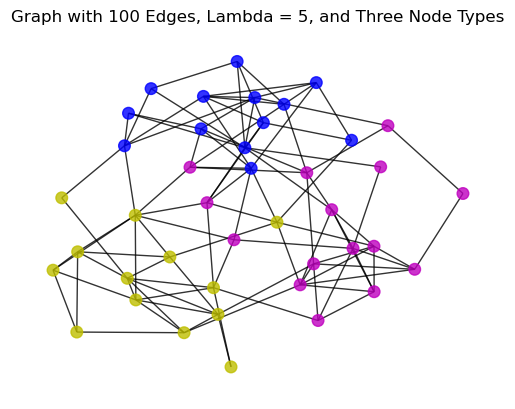

In [372]:
M = np.array([[0.8, 0.2, 0.2],
              [0.2, 0.8, 0.2],
              [0.2, 0.2, 0.8]])
graph_1 = MixedNetworkFormation(M=M, poisson_lambda=5, num_edges=100)
graph_1_handler = graphHandler(graph_1.getGraph(), graph_1.getGroundTruthColors(), use_pydot=True)
graph_1_handler.showGraph(title='Graph with 100 Edges, Lambda = 5, and Three Node Types')

In [438]:
sorted_betweenness = betweenness(graph_1.getGraph())

In [426]:
sorted_centrality = eigenvector_centrality(graph_1.getGraph())
early_adopters = choose_early_adopters(sorted_centrality)
early_adopters

{11, 27}

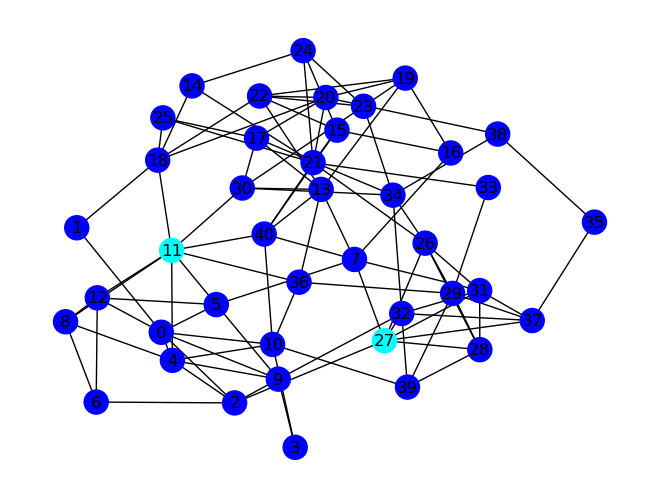

In [405]:
population = Population(graph_1.getGraph, lambda _: early_adopters)
graph_1_sim = Simulation('graph_1', population, graph_1_handler.pos)
graph_1_sim.run()

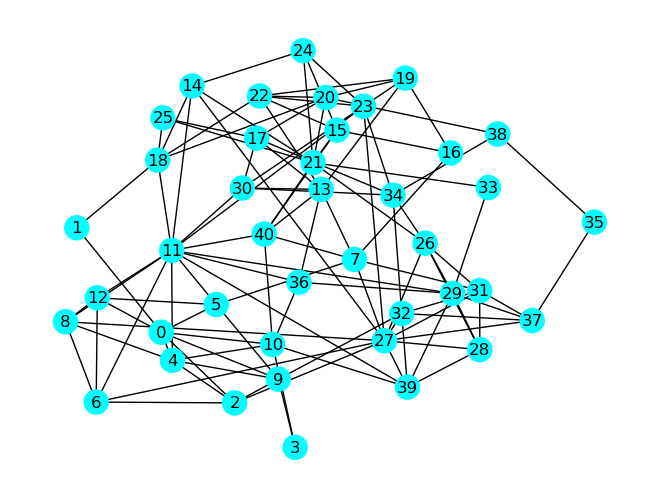

In [459]:
population = Population(lambda: add_edges(graph_1.getGraph(), sorted_centrality, sorted_betweenness, early_adopters, weight_by_centrality=True, infiltrate_with_min=True, reverse_betweenness=True), lambda _: early_adopters)
graph_1_sim = Simulation('graph_1', population, graph_1_handler.pos, n_trials=1000)
graph_1_sim.run()

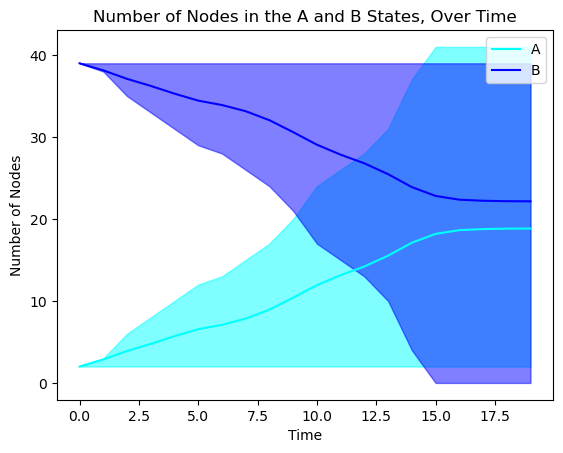

In [460]:
graph_1_sim.plot(show_iqr=True)

### Graph with 200 Edges, Lambda = 5, and Three Node Types

/var/folders/y1/r6lw81g960n148db75yhq7140000gn/T/ipykernel_14063/1583106224.py:6: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  if use_pydot: self.pos = nx.nx_pydot.graphviz_layout(self.G,prog='neato')


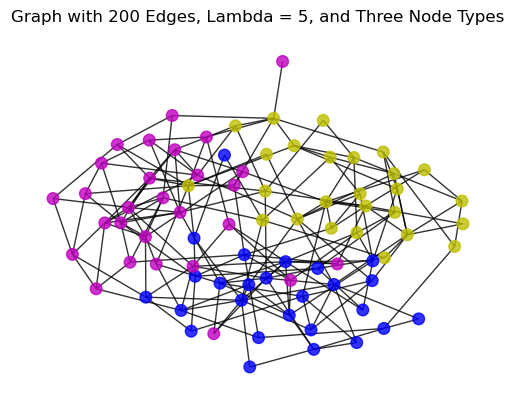

In [461]:
M = np.array([[0.8, 0.2, 0.2],
              [0.2, 0.8, 0.2],
              [0.2, 0.2, 0.8]])
graph_2 = MixedNetworkFormation(M=M, poisson_lambda=5, num_edges=200)
graph_2_handler = graphHandler(graph_2.getGraph(), graph_2.getGroundTruthColors(), use_pydot=True)
graph_2_handler.showGraph(title='Graph with 200 Edges, Lambda = 5, and Three Node Types')

In [462]:
sorted_betweenness = betweenness(graph_2.getGraph())

In [463]:
sorted_centrality = eigenvector_centrality(graph_2.getGraph())
early_adopters = choose_early_adopters(sorted_centrality)

early_adopters

{47, 62, 66, 68}

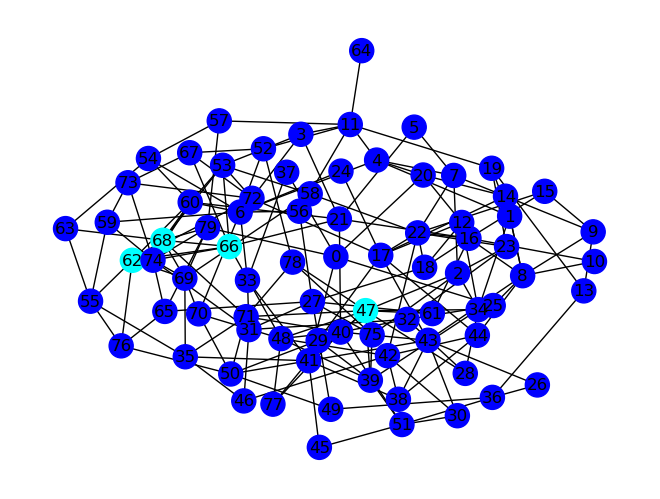

In [465]:
population = Population(graph_2.getGraph, lambda _: early_adopters)
graph_2_sim = Simulation('graph_2', population, graph_2_handler.pos)
graph_2_sim.run()

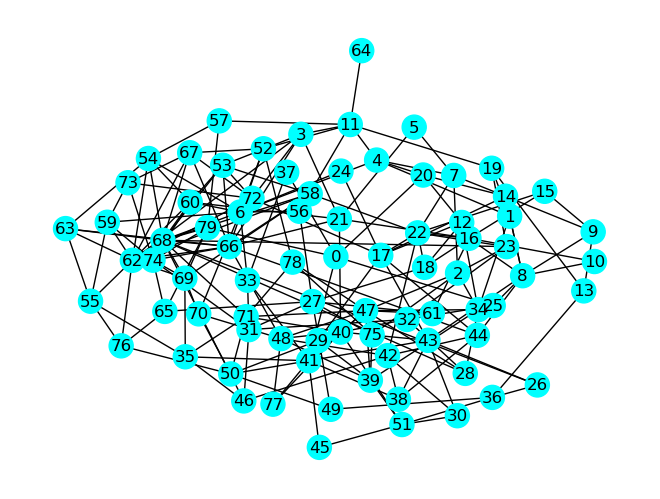

In [466]:
population = Population(lambda: add_edges(graph_2.getGraph(), sorted_centrality, sorted_betweenness, early_adopters, weight_by_centrality=True, infiltrate_with_min=True, reverse_betweenness=True), lambda _: early_adopters)
graph_2_sim = Simulation('graph_2', population, graph_2_handler.pos, n_trials=1000)
graph_2_sim.run()

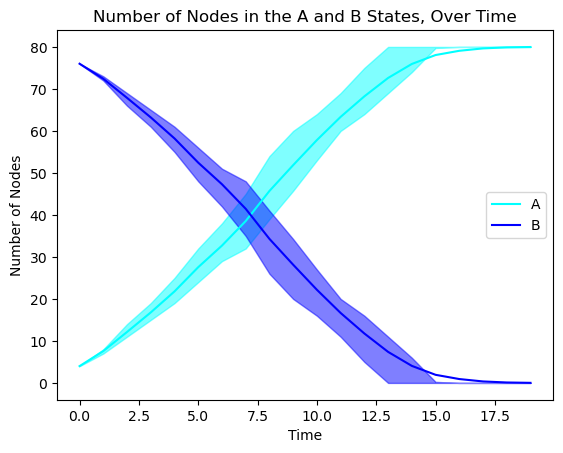

In [467]:
graph_2_sim.plot(show_iqr=True)

### Graph with 200 Edges, Lambda = 5, and Four Node Types

/var/folders/y1/r6lw81g960n148db75yhq7140000gn/T/ipykernel_14063/1583106224.py:6: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  if use_pydot: self.pos = nx.nx_pydot.graphviz_layout(self.G,prog='neato')


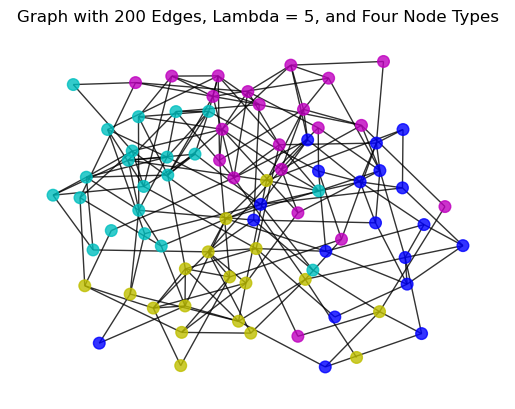

In [468]:
M = np.array([[0.8, 0.2, 0.2, 0.2],
              [0.2, 0.8, 0.2, 0.2],
              [0.2, 0.2, 0.8, 0.2],
              [0.2, 0.2, 0.2, 0.8]])
graph_3 = MixedNetworkFormation(M=M, poisson_lambda=5, num_edges=200)
graph_3_handler = graphHandler(graph_3.getGraph(), graph_3.getGroundTruthColors(), use_pydot=True)
graph_3_handler.showGraph(title='Graph with 200 Edges, Lambda = 5, and Four Node Types')

In [469]:
sorted_betweenness = betweenness(graph_3.getGraph())

In [470]:
sorted_centrality = eigenvector_centrality(graph_3.getGraph())
early_adopters = choose_early_adopters(sorted_centrality)

early_adopters

{50, 57, 59, 72}

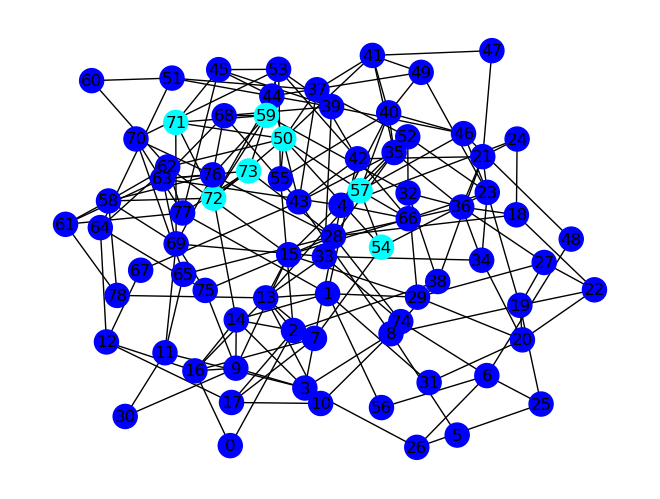

In [471]:
population = Population(graph_3.getGraph, lambda _: early_adopters)
graph_3_sim = Simulation('graph_3', population, graph_3_handler.pos)
graph_3_sim.run()

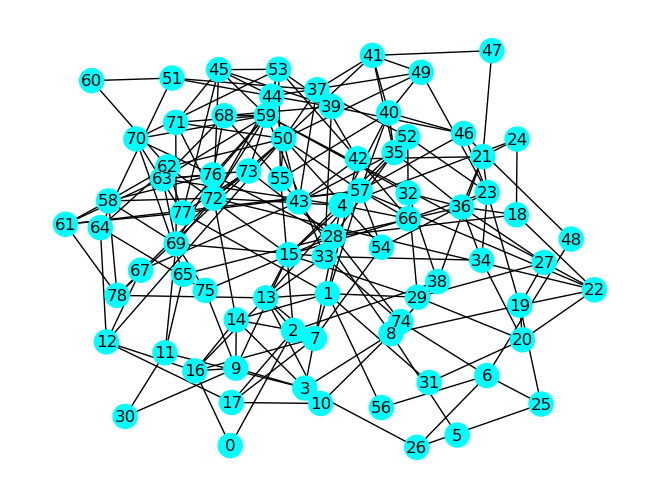

In [476]:
population = Population(lambda: add_edges(graph_3.getGraph(), sorted_centrality, sorted_betweenness, early_adopters, weight_by_centrality=True, infiltrate_with_min=True, reverse_betweenness=True), lambda _: early_adopters)
graph_3_sim = Simulation('graph_3', population, graph_3_handler.pos, n_trials=1000)
graph_3_sim.run()

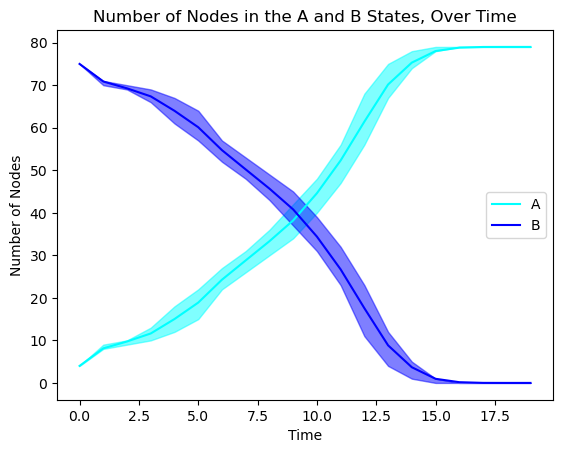

In [477]:
graph_3_sim.plot(show_iqr=True)

### Graph with 200 Edges, Lambda = 5, and Six Node Types

/var/folders/y1/r6lw81g960n148db75yhq7140000gn/T/ipykernel_14063/1583106224.py:6: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  if use_pydot: self.pos = nx.nx_pydot.graphviz_layout(self.G,prog='neato')


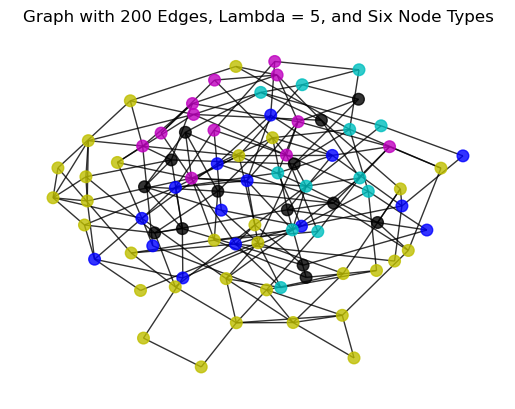

In [483]:
M = np.array([[0.8, 0.2, 0.2, 0.2, 0.2, 0.2],
              [0.2, 0.8, 0.2, 0.2, 0.2, 0.2],
              [0.2, 0.2, 0.8, 0.2, 0.2, 0.2],
              [0.2, 0.2, 0.2, 0.8, 0.2, 0.2],
              [0.2, 0.2, 0.2, 0.2, 0.8, 0.2],
              [0.2, 0.2, 0.2, 0.2, 0.2, 0.8]])
graph_4 = MixedNetworkFormation(M=M, poisson_lambda=5, num_edges=200)
graph_4_handler = graphHandler(graph_4.getGraph(), graph_4.getGroundTruthColors(), use_pydot=True)
graph_4_handler.showGraph(title='Graph with 200 Edges, Lambda = 5, and Six Node Types')

In [484]:
sorted_betweenness = betweenness(graph_4.getGraph())

In [485]:
sorted_centrality = eigenvector_centrality(graph_4.getGraph())
early_adopters = choose_early_adopters(sorted_centrality)
early_adopters

{23, 41, 45, 75}

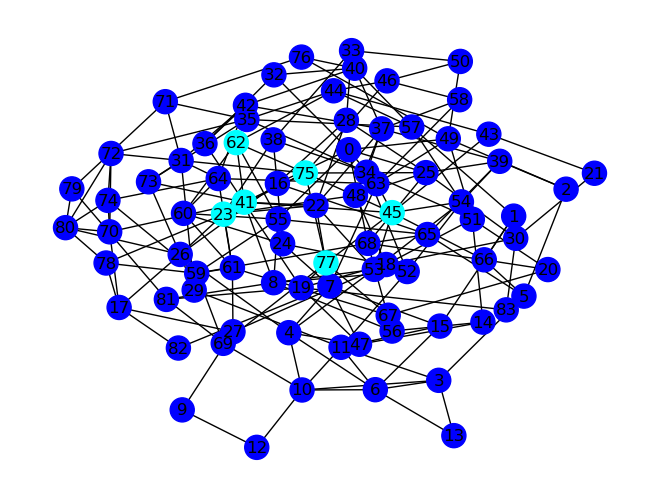

In [486]:
population = Population(graph_4.getGraph, lambda _: early_adopters)
graph_4_sim = Simulation('graph_4', population, graph_4_handler.pos)
graph_4_sim.run()

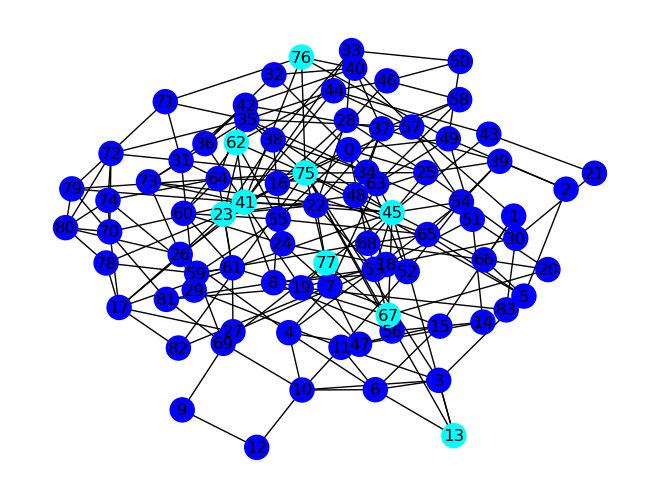

In [491]:
population = Population(lambda: add_edges(graph_4.getGraph(), sorted_centrality, sorted_betweenness, early_adopters, weight_by_centrality=True, infiltrate_with_min=True, reverse_betweenness=True), lambda _: early_adopters)
graph_4_sim = Simulation('graph_4', population, graph_4_handler.pos, n_trials=1000)
graph_4_sim.run()

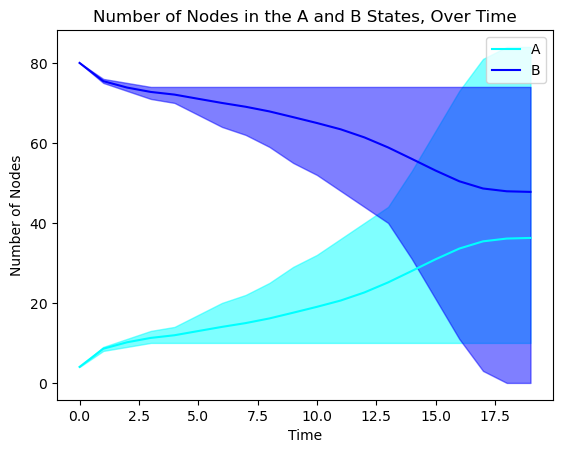

In [492]:
graph_4_sim.plot(show_iqr=True)

### Graph with 300 Edges, Lambda = 10, and Six Node Types

/var/folders/y1/r6lw81g960n148db75yhq7140000gn/T/ipykernel_14063/1583106224.py:6: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  if use_pydot: self.pos = nx.nx_pydot.graphviz_layout(self.G,prog='neato')


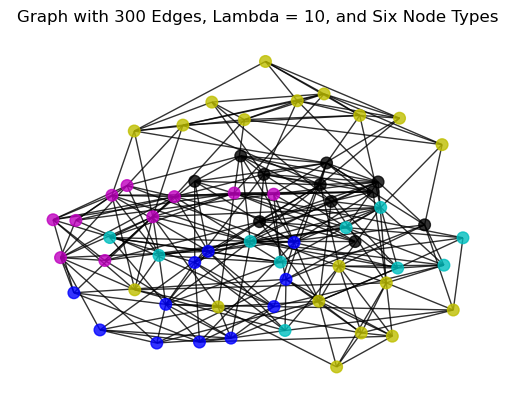

In [529]:
M = np.array([[0.8, 0.2, 0.2, 0.2, 0.2, 0.2],
              [0.2, 0.8, 0.2, 0.2, 0.2, 0.2],
              [0.2, 0.2, 0.8, 0.2, 0.2, 0.2],
              [0.2, 0.2, 0.2, 0.8, 0.2, 0.2],
              [0.2, 0.2, 0.2, 0.2, 0.8, 0.2],
              [0.2, 0.2, 0.2, 0.2, 0.2, 0.8]])
graph_5 = MixedNetworkFormation(M=M, poisson_lambda=10, num_edges=300)
graph_5_handler = graphHandler(graph_5.getGraph(), graph_5.getGroundTruthColors(), use_pydot=True)
graph_5_handler.showGraph(title='Graph with 300 Edges, Lambda = 10, and Six Node Types')

In [530]:
sorted_betweenness = betweenness(graph_5.getGraph())

In [574]:
sorted_centrality = eigenvector_centrality(graph_5.getGraph())
early_adopters = choose_early_adopters(sorted_centrality)
early_adopters

{24, 38, 39}

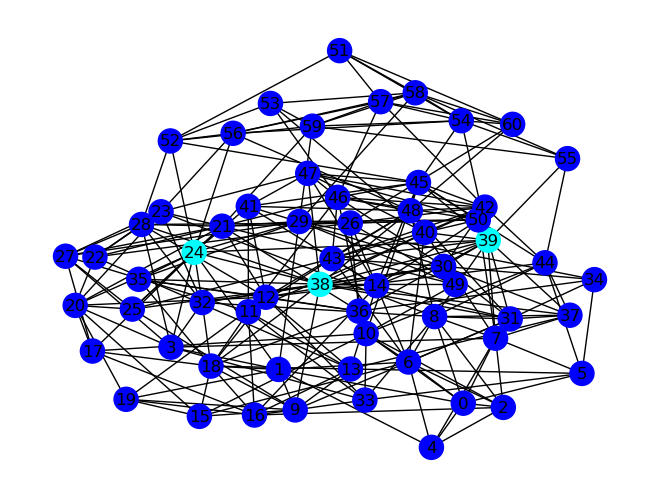

In [575]:
population = Population(graph_5.getGraph, lambda _: early_adopters)
graph_5_sim = Simulation('graph_5', population, graph_5_handler.pos)
graph_5_sim.run()

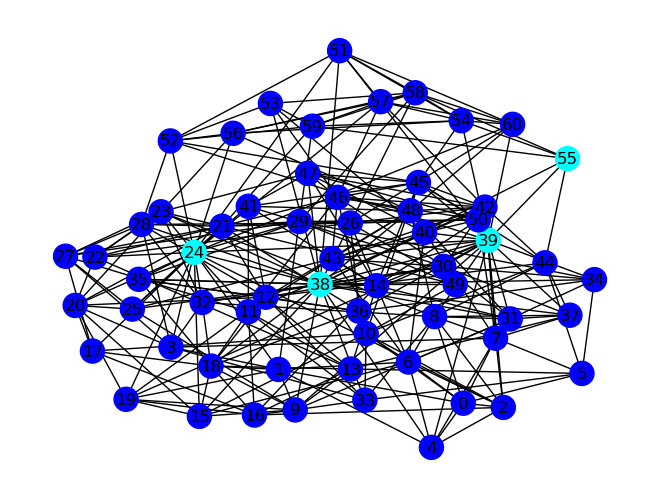

In [576]:
population = Population(lambda: add_edges(graph_5.getGraph(), sorted_centrality, sorted_betweenness, early_adopters, weight_by_centrality=True, infiltrate_with_min=True, reverse_betweenness=True), lambda _: early_adopters)
graph_5_sim = Simulation('graph_5', population, graph_5_handler.pos, n_trials=1000)
graph_5_sim.run()

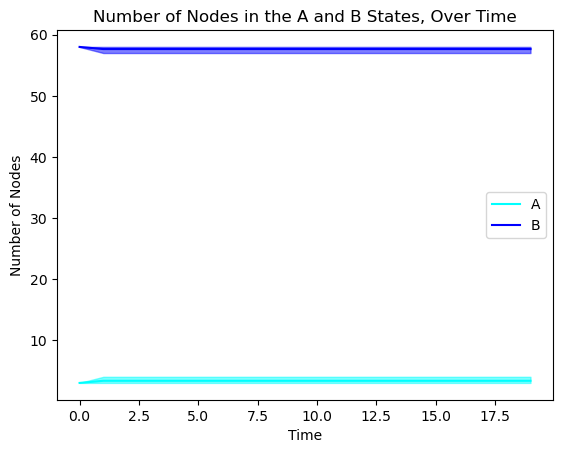

In [577]:
graph_5_sim.plot(show_iqr=True)

In [ ]:
# TODO: 
#   - Only add edges to early adopters where it's possible for them to convert
#       - Pre-compute how many edges would need to be added for each node (ignore nodes where it's impossible), and start with nodes that require the fewest number of edge additions
#   - Create a function that is the same as add_edges, but checks if a node could (in theory) be converted; if so, add edges from that node to as many early adopters as needed (randomly sample from the early adopters, possibly weighted by centrality)
#   - Create a function to calculate a few graph metrics (for the report)